# Basics of mobile robotics project report

# Introduction

# 1. Vision

## Cropping and resizing of the image

In [20]:
import cv2
import math
from math import cos, sin, degrees, radians
import numpy as np
import matplotlib.pyplot as plt
import MTM
from MTM import matchTemplates, drawBoxesOnRGB
from scipy import ndimage, misc
import sys
import os
sys.path.insert(0, os.path.join(os.getcwd(), 'src'))
from myThymio import MyThymio
from utils.filter_utils import *
from utils.map_utils import get_pattern
from myThymio.thymio_constants import *
from utils.controller_utils import controller

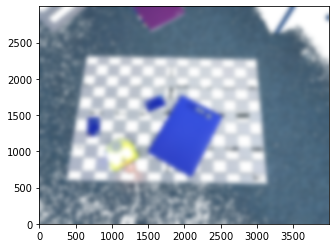

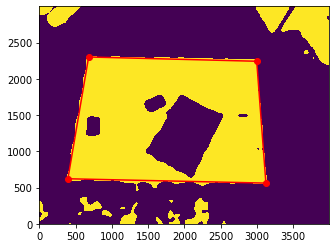

In [2]:
img = cv2.imread('images/terrain.jpg')[::-1,:,:]
kernel_size = 201
black_min = np.array([0, 0, 0])
black_max = np.array([80, 80, 80])

mask=cv2.inRange(img,black_min,black_max)

img_no_black = img.copy()
img_no_black[mask>0]=(255,255,255)

blurred_img = cv2.GaussianBlur(img_no_black,(kernel_size,kernel_size),0)


(b, g, r) = cv2.split(blurred_img)
_,threshold = cv2.threshold(b, 150, 255,  
                            cv2.THRESH_BINARY) 

plt.imshow(blurred_img, origin='lower')
plt.figure()
plt.imshow(threshold, origin='lower')

# Detecting shapes in image by selecting region with same colors or intensity.
contours,_=cv2.findContours(threshold, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

board = None

# Searching through every region selected to find the required polygon.
for cnt in contours : 
    area = cv2.contourArea(cnt) 

    # Shortlisting the regions based on there area. 
    if area > 1000000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.05
                                  * cv2.arcLength(cnt, True), True) 
        if len(approx) == 4 or True:
            board = approx

n= len(board)
for i in range(n):
    vertice1 = board[i][0]
    vertice2 = board[(i+1)%n][0]
    plt.scatter(vertice1[0], vertice1[1], c='r')
    plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'r')
   

In [3]:
top_left_idx = None
for i in range(len(board)):
    vertice1 = board[i][0]
    if vertice1[0] < threshold.shape[0] and vertice1[1] < threshold.shape[1]:
        top_left_idx = i
        break
new_board = []
for i in range(len(board)):
    idx = (top_left_idx + i)%4
    new_board.append(board[idx][0])

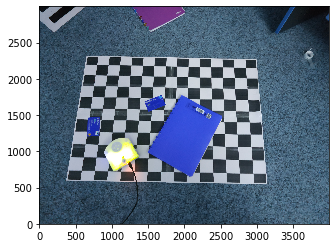

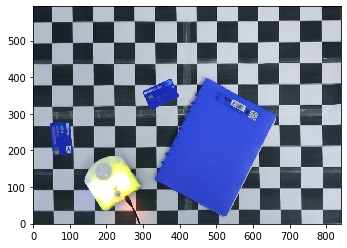

In [4]:
pts0 = np.float32(new_board)

W, H = 420*2, 297*2
# Define corresponding points in output image
pts1 = np.float32([[0,0],[0,H],[W,H],[W,0]])

# Get perspective transform and apply it
M = cv2.getPerspectiveTransform(pts0,pts1)
rescaled_img = cv2.warpPerspective(img,M,(W,H))

# Save reult
plt.imshow(img, origin='lower')
plt.figure()
plt.imshow(rescaled_img, origin='lower')

## Location of the thymio and the goal

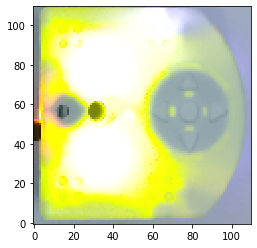

In [5]:
template_1 = cv2.resize(cv2.imread('images/thymio.jpg')[::-1,:,:], dsize=(110, 110), interpolation=cv2.INTER_CUBIC)
plt.imshow(template_1, origin='lower')

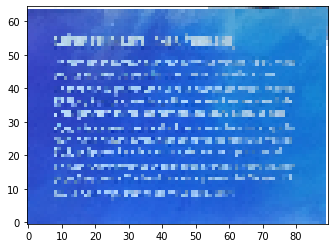

In [6]:
template_2 = cv2.resize(cv2.imread("images/destination.png")[::-1,:,:], dsize=(90, 65), interpolation=cv2.INTER_CUBIC)
plt.imshow(template_2, origin='lower')

In [7]:
def find_object(template, rescaled_img, angle_resolution):
    best_angle = 0
    best = 0
    best_Hit = []
    for angle in np.arange(0, 359, angle_resolution):
        rotated = ndimage.rotate(template, angle) 
        name = "".join(["thymio_", str(angle)])
        listTemplate = [(name, rotated)]
        Hit = matchTemplates(listTemplate, rescaled_img,method=cv2.TM_CCOEFF_NORMED, N_object=1,score_threshold=0.1, maxOverlap=0,searchBox=None)
        if Hit.Score.to_numpy()[0] > best:
            best_Hit = Hit
            best_angle = angle
            best = Hit.Score.to_numpy()[0]
    theta = radians(best_angle)
    return best_Hit, theta

In [8]:
### Find the thymio
Thymio_Hit, angle_thymio = find_object(template_1, rescaled_img, 1)
corner_thymio = Thymio_Hit.BBox.to_numpy()[0][0:2]
size_thymio = Thymio_Hit.BBox.to_numpy()[0][2:4]
center_thymio = np.array(corner_thymio) + np.array(size_thymio)/2

In [9]:
### Find the destination
Destination_Hit, angle_destination = find_object(template_2, rescaled_img, 10)
corner_destination = Destination_Hit.BBox.to_numpy()[0][0:2]
size_destination = Destination_Hit.BBox.to_numpy()[0][2:4]
center_dest = np.array(corner_destination) + np.array(size_destination)/2

Position of the thymio and destination output 

(225.03630046304096, 96.02728979905415, -4.066617157146788)


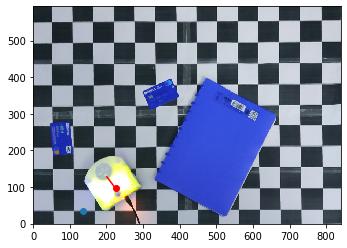

In [10]:
plt.imshow(rescaled_img, origin='lower')
plt.scatter(corner_thymio[0], corner_thymio[1])
# plt.scatter(center_dest[0], center_dest[1])

theta = angle_thymio
forward = np.array([-cos(theta), sin(theta)])
wheel_center = center_thymio + forward*20
plt.scatter(wheel_center[0], wheel_center[1], c='r')
thymio_pos = (wheel_center[0], wheel_center[1] , -theta)

x, y = wheel_center
length = 40
plt.plot((x, x + length * math.cos(-theta)), (y, y + length * math.sin(-theta)), "r")

print(thymio_pos)

In [11]:
destination = (750, 150)

## Generation of the obstacle  map

Remove black pattern in the background

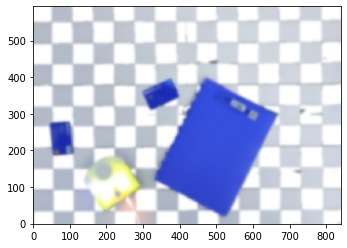

In [12]:
filtered_img = cv2.bilateralFilter(rescaled_img,21, 75, 75)
black_min = np.array([0, 0, 0])
black_max = np.array([100, 100, 100])

mask=cv2.inRange(filtered_img,black_min,black_max)
plt.imshow(filtered_img)

filtered_img[mask>0]=(255,255,255)

kernel_size = 21
filtered_img = cv2.GaussianBlur(filtered_img,(kernel_size,kernel_size),0)

plt.imshow(filtered_img, origin='lower')

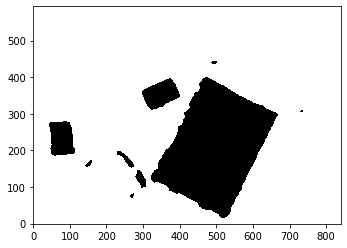

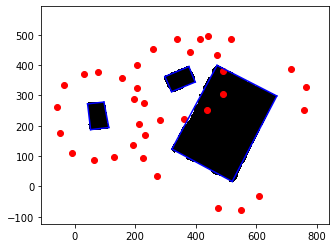

In [13]:
### Image processing filter

threshold_val = 170

#Find the thymio and the destination

(b, g, r) = cv2.split(filtered_img)
ret2, thresh2 = cv2.threshold(b, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret3, thresh3 = cv2.threshold(g, threshold_val, 255, cv2.THRESH_BINARY_INV)
ret4, thresh4 = cv2.threshold(r, threshold_val, 255, cv2.THRESH_BINARY_INV)
bgr_thresh = cv2.merge((thresh2, thresh3, thresh4))

black_and_white = thresh3

plt.imshow(black_and_white, cmap='Greys', origin='lower')

# Detecting shapes in image by selecting region with same colors or intensity

contours,_=cv2.findContours(black_and_white, cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE) 

obstacles =  []

# Searching through every region selected to find the required polygon

for cnt in contours : 
    area = cv2.contourArea(cnt) 
   
    # Shortlisting the regions based on there area 
    if area > 2000:  
        approx = cv2.approxPolyDP(cnt,  
                                  0.03 * cv2.arcLength(cnt, True), True) 
        obstacles.append(approx)
    else:
        cv2.drawContours(black_and_white, [cnt], -1, 0, thickness=-1)
    
plt.figure()

plt.imshow(black_and_white, cmap='Greys', origin='lower')

obstacle_map = black_and_white

from numpy import sqrt
def norm(vec):
    return sqrt(vec[0]**2 + vec[1]**2)

MARGIN = 100

way_points = []

for obstacle in obstacles:
    n= len(obstacle)
    for i in range(n):
        vertice1 = obstacle[i][0]
        vertice2 = obstacle[(i+1)%n][0]
        vertice3 = obstacle[(i+2)%n][0]
        
        vec1 = vertice2 - vertice1
        vec2 = vertice2 - vertice3
        
        normal_vec = vec1/norm(vec1) + vec2/norm(vec2)
        way_point1 = vertice2 + vec1*MARGIN/norm(vec1)
        way_point2 = vertice2 + vec2*MARGIN/norm(vec2)
        way_point3 = vertice2 + normal_vec*MARGIN/norm(normal_vec)
        
        way_points.append(way_point1)
        way_points.append(way_point2)
        way_points.append(way_point3)
        
        plt.scatter(way_point1[0], way_point1[1], c='r')
        plt.scatter(way_point2[0], way_point2[1], c='r')
        plt.scatter(way_point3[0], way_point3[1], c='r')
        plt.plot((vertice1[0], vertice2[0]), (vertice1[1], vertice2[1]), 'b')

# 2. Global navigation



## Graph generation

In [14]:
import itertools

# Create a class fro each node

class Node:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.gScore = np.inf
        self.fScore = np.inf
        self.neighbours = []
    def plot(self, color = 'r'):
        plt.scatter(self.x, self.y, c=color)
    def get_pos(self):
        return self.x, self.y
    def __repr__(self):
        return "node ("+str(self.x)+","+str(self.y)+")"
#     def __eq__(self, other):
#         return self.x == other.x and self.y == other.y
#     def __hash__(self):
#         return hash((self.x, self.y))
    
def sample_image(obstacle_map, x, y):
    max_y = obstacle_map.shape[0]
    max_x = obstacle_map.shape[1]
    if x >= max_x or x < 0 or y >= max_y or y < 0:
        return 255
    else:
        return obstacle_map[y][x]

# Find if there is any obstacle between two consecutives nodes

def noObstacleBetween(p1, p2):
    RESOLUTION = 10
    
    x, y = p1
    x_end, y_end = p2
    forward = np.array([x_end - x, y_end - y])
    
    dist = np.linalg.norm(forward)
    if dist == 0:
        return False
    
    forward = forward/dist
    perp = np.array([forward[1], -forward[0]])
    
    
    for perp_dist in np.arange(-MARGIN*0.7, MARGIN*0.7, RESOLUTION):
        for forward_dist in np.arange(0, dist, RESOLUTION):
            sample_point = np.array(p1) + forward_dist*forward + perp_dist*perp
#             plt.scatter(sample_point[0], sample_point[1], c='g')
            intensity = sample_image(obstacle_map, int(sample_point[0]), int(sample_point[1]))
            if intensity == 255:
                return False
    return True

#Create the graph of the map

class Graph:
    def __init__(self, way_points):
        self.nodes = []
        for way_point in way_points:
            x, y = way_point
            self.nodes.append(Node(x, y))
        for node1, node2 in itertools.combinations(self.nodes, 2):
            if noObstacleBetween(node1.get_pos(), node2.get_pos()):
                node1.neighbours.append(node2)
                node2.neighbours.append(node1)

                x, y = node1.get_pos()
                x_end, y_end = node2.get_pos()
                plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
                
    def add_new_node(self, node):
        for potential_neighbour in self.nodes:
            if noObstacleBetween(node.get_pos(), potential_neighbour.get_pos()):
                node.neighbours.append(potential_neighbour)
                potential_neighbour.neighbours.append(node)
                
#                 x, y = node.get_pos()
#                 x_end, y_end = potential_neighbour.get_pos()
#                 plt.plot((x, x_end), (y, y_end), 'm', linewidth=1)
        self.nodes.append(node)
        
# plt.imshow(obstacle_map, cmap='Greys')
# noObstacleBetween((10, 10), (1000, 2000))

Node graph output

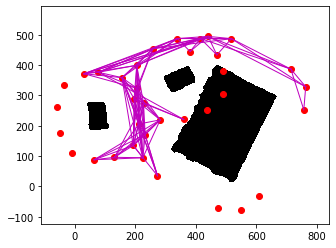

In [15]:
plt.imshow(obstacle_map, cmap='Greys', origin='lower')

graph = Graph(way_points)

for node in graph.nodes:
    node.plot()

## Path finding using A*

In [16]:
# Evaluate the distance 

def distance(node1, node2):
    return sqrt((node1.x-node2.x)**2 + (node1.y - node2.y)**2)

### Path computation

def A_Star(start, goal, h):
    for node in graph.nodes:
        node.gScore = np.inf
        node.fScore = np.inf
    
    openSet = [start]
    start.gScore = 0
    closedSet = []
    
    cameFrom = dict()
    
    while openSet != []:
        current = min(openSet, key=lambda node: node.fScore)
        if current == goal:
            path = [current]
            while current in cameFrom.keys():
                path.insert(0, cameFrom[current]) 
                current=cameFrom[current]
            return path, closedSet
        
        openSet.remove(current)
        closedSet.append(current)
        
        for neighbour in current.neighbours:
            if neighbour in closedSet:
                continue
                
            tentative_gScore = current.gScore + distance(current, neighbour)
            
            if neighbour not in openSet:
                openSet.append(neighbour)
            
            if tentative_gScore < neighbour.gScore:
                cameFrom[neighbour] = current
                neighbour.gScore = tentative_gScore
                neighbour.fScore = neighbour.gScore + h(neighbour)
    print("No path found to goal")
    return None, closedSet

def compute_path(start, goal, graph):
    graph.add_new_node(start)
    graph.add_new_node(goal)
    
    h = lambda node: distance(node, goal)
    path_nodes, closedSet = A_Star(start, goal, h)
    
    path = []
    for node in path_nodes:
        x, y = node.get_pos()
        path.append((x, y, 0))
    
    # Draw
    for node in graph.nodes:
        node.plot()
    for node in closedSet:
        node.plot('m')
    if path!=None:
        for i in range(len(path_nodes)-1):
            x, y = path_nodes[i].get_pos()
            x_end, y_end = path_nodes[i+1].get_pos()
            plt.plot((x, x_end), (y, y_end), 'g', linewidth=3)
    start.plot('g')
    goal.plot('b')
    
    return path


Global Path output

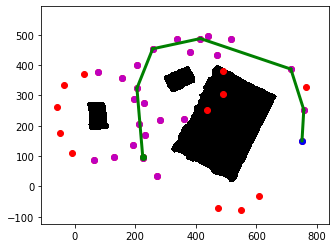

In [17]:
plt.imshow(obstacle_map, cmap='Greys', origin='lower')

start = Node(thymio_pos[0], thymio_pos[1])
goal = Node(destination[0], destination[1])

path = compute_path(start, goal, graph)

# Filtering

In [18]:
# %load -n particle_filter
def particle_filter(
    particle_pos_list, speed_left_m, speed_right_m, ground_left_measure, ground_right_measure, dt
):
    weights = np.empty([NUMBER_OF_PARTICLES * NEW_GEN_NUMBER])

    new_generation = []
    i = 0
    for particle_pos in particle_pos_list:
        for _ in range(NEW_GEN_NUMBER):
            # create the new generation using the motion uncertainty model
            speed_left = np.random.normal(speed_left_m, SIGMA_V)
            speed_right = np.random.normal(speed_right_m, SIGMA_V)
            new_pos = update_pos(particle_pos, speed_left, speed_right, dt)
            new_generation.append(new_pos)

            # estimate the probability of the measurement if the robot was at this position, and use it as weight
            weights[i] = ground_measurement_probability(new_pos, ground_left_measure, ground_right_measure)

            i += 1

    # sample the new generation according to the weights
    indices = range(len(new_generation))
    sample = np.random.choice(indices, size=NUMBER_OF_PARTICLES, replace=True, p=weights / np.sum(weights))

    new_particles = [new_generation[i] for i in sample]

    return new_particles

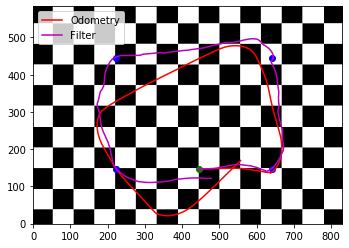

In [19]:
import json

# read the data from the file
with open('saved_data.txt', 'r') as filehandle:
    (path, initial_pos, saved_data) = json.load(filehandle)

pos_odometry = initial_pos
    
NUMBER_OF_PARTICLES = 70
particle_pos_list = [initial_pos for _ in range(NUMBER_OF_PARTICLES)]

odometry_pos_history = np.array((initial_pos[0], initial_pos[1]))
filter_pos_history = np.array((initial_pos[0], initial_pos[1]))
for data in saved_data:
    speed_left, speed_right, ground_left_measure, ground_right_measure, time_diff = data
    
    # localization using only odometry
    pos_odometry = update_pos(pos_odometry, speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, time_diff)
    
    # localization using the filter
    particle_pos_list = particle_filter(
        particle_pos_list, 
        speed_left * THYMIO_SPEED_TO_MMS, speed_right * THYMIO_SPEED_TO_MMS, ground_left_measure, ground_right_measure,
        time_diff)
    pos_filter = np.mean(particle_pos_list, axis=0)
    
    # save the results to plot afterward
    filter_pos_history = np.vstack((filter_pos_history, (pos_filter[0], pos_filter[1])))
    odometry_pos_history = np.vstack((odometry_pos_history, (pos_odometry[0], pos_odometry[1])))

# plot results
for point in path:
    x, y, theta = point
    plt.scatter(x, y, c="b")
    
pattern = get_pattern()
plt.imshow(pattern, cmap="Greys", origin="lower")
plt.scatter(initial_pos[0], initial_pos[1], c='g')
plt.plot(odometry_pos_history[:, 0], odometry_pos_history[:, 1], 'r', label='Odometry')
plt.plot(filter_pos_history[:, 0], filter_pos_history[:, 1], 'm', label='Filter')
plt.legend()

# 3. Control

In [ ]:
# %load -n controller
def controller(current_pos, target_pos):
    x, y, theta = current_pos
    x_d, y_d, theta_d = target_pos

    x_r = x - x_d
    y_r = y - y_d
    rho = sqrt(x_r ** 2 + y_r ** 2)
    gamma = normalize_angle(atan2(y_r, x_r) - theta + pi)
    delta = normalize_angle(gamma + theta + theta_d)

    if gamma == 0:
        gamma = 0.0001

    k1 = 1.2  # affects linear speed
    k2 = 0.8  # affects rotational speed
    k3 = 0  # affects how much getting to the final angle matters

    v = k1 * rho * cos(gamma)**3
    omega = k2 * gamma + k1 * sin(gamma) * cos(gamma) / gamma * (gamma + k3 * delta)

    v = min(50, max(-50, v))
    omega = min(3, max(-3, omega))

    speed_left = (v - WHEELS_SPACING * omega / 2)
    speed_right = (v + WHEELS_SPACING * omega / 2)
    return speed_left, speed_right

# 4. Local Navigation

# 5. Run the code

In [ ]:
TIME_STEP = 0.1
myThymio = MyThymio(port="COM3", initial_pos=thymio_pos, robot_path=path, refreshing_rate=2 * TIME_STEP)
myThymio.run()